In [88]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# get file path from config
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from config import BASE_PATH

In [22]:
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
fp = os.path.join(BASE_PATH,"dataset","user_pay.txt")
df = pd.read_csv(fp,header=None, engine='c', sep=',')
df.columns = ["user_id", "shop_id", "datetime"]

In [72]:
#print df[(df["datetime"]>="2016-09-17") & (df["datetime"]<"2016-09-18")]
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['datetime'].dt.date)
print df.head()

    user_id  shop_id            datetime       date
0  22127870     1862 2015-12-25 17:00:00 2015-12-25
1   3434231     1862 2016-10-05 11:00:00 2016-10-05
2  16955285     1862 2016-02-10 15:00:00 2016-02-10
3  13799128     1862 2016-01-13 14:00:00 2016-01-13
4  13799128     1862 2016-07-05 12:00:00 2016-07-05


In [73]:
df_grp_by_day = df.groupby(['shop_id', 'date']).size()
print df_grp_by_day.head()

shop_id  date      
1        2015-10-10    188
         2015-10-11    272
         2015-10-12    257
         2015-10-13    239
         2015-10-14    277
dtype: int64


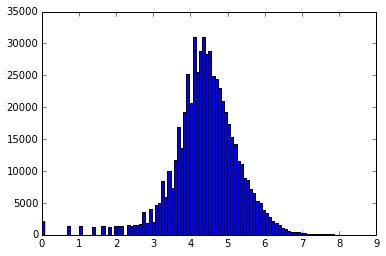

In [74]:
plt.hist(np.log(df_grp_by_day),bins=100)
plt.show()
# per shop per day frequency

In [115]:
shop_slice = df_grp_by_day[100]["2015-01-01":"2016-10-01"]

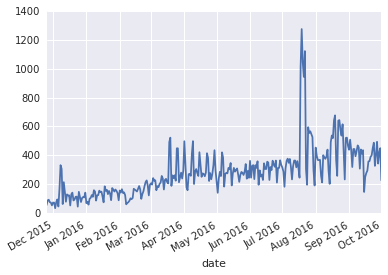

In [116]:
shop_slice.plot()

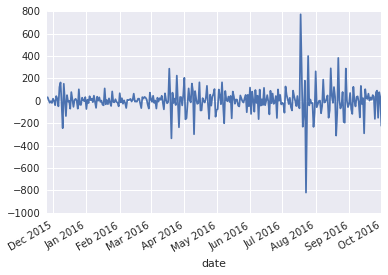

In [117]:
shop_slice_diff1 = shop_slice-shop_slice.shift(1)
shop_slice_diff1.plot()

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(shop_slice)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index